In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import sys
import numpy as np
import tensorrt
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

In [2]:
# import tensorrt
# print(tensorrt.__version__)
# from medclip.run_medclip import Transform

from transformers import AutoTokenizer, HfArgumentParser, TrainingArguments, is_tensorboard_available, set_seed
has_tensorboard = is_tensorboard_available()
if has_tensorboard:
    try:
        from flax.metrics.tensorboard import SummaryWriter
    except ImportError as ie:
        has_tensorboard = False
        print(f"Unable to display metrics through TensorBoard because some package are not installed: {ie}")

else:
    print(
        "Unable to display metrics through TensorBoard because the package is not installed: "
        "Please run pip install tensorboard to enable."
    )

In [3]:
devices = jax.devices()
for device in devices:
    print(f"Device {device.id}: {device.device_kind}, {device.platform}")

Device 0: NVIDIA RTX A1000 Laptop GPU, gpu


In [5]:
# tokenizer_name = "allenai/scibert_scivocab_uncased"
# config = HybridCLIPConfig.from_pretrained("../..")
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
# tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [6]:
# import tensorrt
import gc

# model.cpu()
# del model, checkpoint
gc.collect()
torch.cuda.empty_cache()

In [1]:
import sys
sys.path.append('..')
import tensorrt
from medclip.modeling_hybrid_clip import FlaxHybridCLIP

model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")
# jax.devices()

2023-07-02 15:40:05.306794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)


In [2]:
import os
import json

# Open the file for reading img_dir
# with open('../Experiments/filepath.json', 'r') as f:
#     # Use json.load to read data from file
#     data = json.load(f)
#     img_root_dir = data['roco-dataset']
# img_dir = os.path.join(img_root_dir, 'data/test/radiology/images')
img_dir = '../Experiments/test/'

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "ROCO_00001.jpg"
caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)

ROCO_00031.jpg


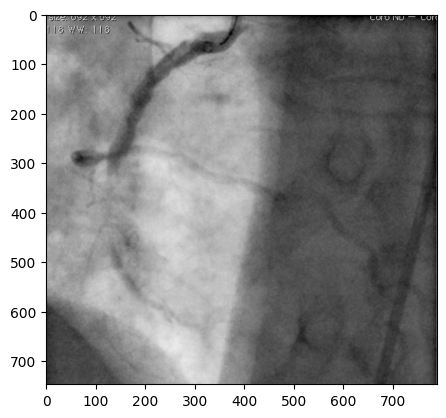

In [5]:
# Let's load a sample image
import os
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(os.path.join(img_dir, img_path))
plt.imshow(img, aspect='equal', cmap='gray')

In [5]:
import tensorrt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available.")
else:
    print("GPU is not available.")
tf.test.gpu_device_name
print(tf.config.list_physical_devices('GPU'))

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
sentences = [f'{c} with' for c in classes]
print(sentences)

['man with', 'woman with']


In [6]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform()
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
outputs = model(**inputs)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 tokenizer = AutoTokenizer.from_pretrained("roberta-base")                                   │
│ ❱  2 img_transforms = Transform()                                                                │
│    3 pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).nump    │
│    4 pixel_values = pixel_values.transpose((1, 2, 0))                                            │
│    5 pixel_values = pixel_values[np.newaxis, ...]                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: Transform.__init__() missing 1 required positional argument: 'image_size'

In [13]:
print(**inputs)

TypeError: 'pixel_values' is an invalid keyword argument for print()

In [14]:
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)

In [15]:
outputs = model(**inputs)

In [27]:
outputs.logits_per_image.shape

['1', '2']


In [17]:
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')

man with: nan
woman with: nan


In [18]:
# Open the file for reading img_dir
with open('../Experiments/filepath.json', 'r') as f:
    # Use json.load to read data from file
    data = json.load(f)
    img_root_dir = data['roco-dataset']
img_dir = os.path.join(img_root_dir, 'data/test/radiology/images')

query = 'carcinoma'
img_list = os.listdir(img_dir)[10:20]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
outputs = model(**inputs)

In [19]:
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

ROCO_72691.jpg: nan
ROCO_57319.jpg: nan
ROCO_41254.jpg: nan
ROCO_01581.jpg: nan
ROCO_31586.jpg: nan
ROCO_17967.jpg: nan
ROCO_73630.jpg: nan
ROCO_54110.jpg: nan
ROCO_69813.jpg: nan
ROCO_60125.jpg: nan


In [213]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = './demo/image_embeddings.tsv'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [212]:
import nmslib
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

In [37]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]

torch.Size([3, 224, 224])